In [1]:
import math
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from simple import nmf_son
from sklearn.decomposition import NMF


np.random.seed(42)
np.set_printoptions(precision=3)

In [2]:
def plot_scores(fscores, gscores, _lambda, log_scale=True):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if log_scale:
        ax.set_yscale('log')
    ax.plot(fscores)
    ax.plot(gscores)
    ax.plot(fscores + _lambda * gscores)
    ax.legend(['f', 'g', 'total'])

def normalized_similarity(W_ins):
    r = W_ins.shape[1]
    res = np.ones(shape=(r, r)) * -1
    for i in range(r):
        for j in range(r):
            res[i, j] = np.linalg.norm(W_ins[:, i] - W_ins[:, j])
        res[i, :] = res[i, :] / sum(res[i, :])
    return res

In [3]:
mat = scipy.io.loadmat('urban/Urban.mat')
X = mat['X']

In [4]:
m, n = X.shape # (162, 94249)
num_col = int(math.sqrt(n)) # 307

In [5]:
X3d = X.reshape(m, num_col, num_col, order='F')

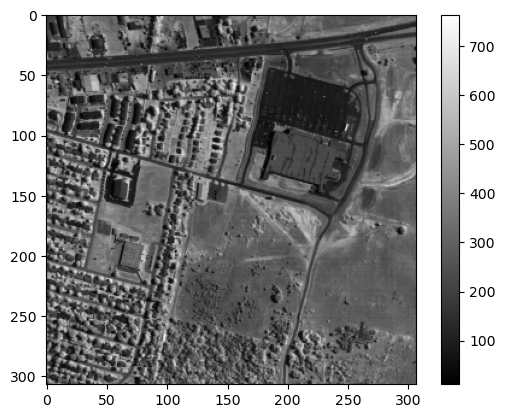

In [6]:
wavelength = 80
plt.imshow(X3d[wavelength, :, :], cmap='gray')
plt.colorbar()

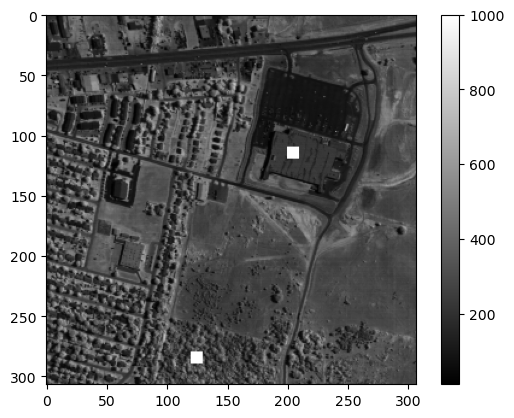

In [7]:
img = X3d[wavelength, :, :].copy()
img[280: 290, 120: 130] = 1000 # trees
img[110: 120, 200: 210] = 1000 # roof
plt.imshow(img, cmap='gray')
plt.colorbar()

In [8]:
trees3d = X3d[:, 280: 290, 120: 130] # (162, 10, 10)
roof3d = X3d[:, 110: 120, 200: 210] # (162, 10, 10)
smallX3d = np.hstack([trees3d, roof3d]) # (162, 20, 10)

In [9]:
# smallX = smallX3d.reshape(m, -1, order='F') # (162, 200)
# with open(f'urban/results/new/small-x.npz', 'wb') as fout:
#     np.savez_compressed(fout, X=smallX)

In [10]:
# rank = 4
# m, n = smallX.shape
#
# iniW = np.random.rand(m, rank)
# iniH = np.random.rand(rank, n)
# with open(f'urban/results/new/small-ini-mat-r{rank}', 'wb') as fout:
#     np.savez_compressed(fout, W=iniW, H=iniH)

In [11]:
# model = NMF(n_components=rank, init='random', random_state=42, max_iter=1000)
# vanillaW = model.fit_transform(smallX)
# vanillaH = model.components_
# with open(f'urban/results/new/nmf-it1000-ini-mat-r{rank}', 'wb') as fout:
#     np.savez_compressed(fout, W=vanillaW, H=vanillaH)

In [12]:
# iter_vals = [200, 500, 1000, 2000, 3000, 4000, 5000]
# rand_file_dict = {0.02: None, 0.2: None, 0.5: None, 2: None, 5: None, 10: None}
#
# for it_idx in range(len(iter_vals)):
#     for lval in rand_file_dict.keys():
#         if rand_file_dict[lval] is None:
#             Wb, Hb, Wl, Hl, fscores, gscores, lambda_vals = nmf_son(smallX, iniW.copy(), iniH.copy(), _lambda=lval, itermax=iter_vals[it_idx], scale_lambda=True)
#         else:
#             data = np.load(rand_file_dict[lval])
#             Wb, Hb, Wl, Hl, fscores, gscores, lambda_vals = nmf_son(smallX, data['Wl'], data['Hl'], _lambda=lval, itermax=iter_vals[it_idx] - iter_vals[it_idx-1], scale_lambda=True)
#             fscores = np.append(data['fscores'][:-1], fscores)
#             gscores = np.append(data['gscores'][:-1], gscores)
#             lambda_vals = np.append(data['lambda_vals'][:-1], lambda_vals)
#
#         save_file = f'urban/results/new/rand-ini-r{rank}-it{iter_vals[it_idx]}-l{str(lval).replace(".", "_")}.npz'
#         with open(save_file, 'wb') as fout:
#             np.savez_compressed(fout, Wb=Wb, Hb=Hb, Wl=Wl, Hl=Hl, fscores=fscores, gscores=gscores, lambda_vals=lambda_vals)
#         rand_file_dict[lval] = save_file
#
#         print(f'done with reg={lval} and it={iter_vals[it_idx]}')

In [13]:
# data = np.load('urban/results/new/rand-ini-r4-it5000-l2.npz')
# Wb, Hb, Wl, Hl, fscores, gscores, lambda_vals = nmf_son(smallX, data['Wl'], data['Hl'], _lambda=2, itermax=45000, scale_lambda=True)
# fscores = np.append(data['fscores'][:-1], fscores)
# gscores = np.append(data['gscores'][:-1], gscores)
# lambda_vals = np.append(data['lambda_vals'][:-1], lambda_vals)
# with open(f'urban/results/new/rand-ini-r4-it50000-l2.npz', 'wb') as fout:
#     np.savez_compressed(fout, Wb=Wb, Hb=Hb, Wl=Wl, Hl=Hl, fscores=fscores, gscores=gscores, lambda_vals=lambda_vals)

In [14]:
smallX = np.load('urban/2022_11_15/data/small-x.npz')['X']
rank = 4
m, n = smallX.shape

ini_mats = np.load(f'urban/2022_11_15/initializations/small-ini-mat-r{rank}')
iniW = ini_mats['W']
iniH = ini_mats['H']

nmf_mats = np.load(f'urban/2022_11_15/initializations/nmf-it1000-ini-mat-r{rank}')
nmfW = nmf_mats['W']
nmfH = nmf_mats['H']

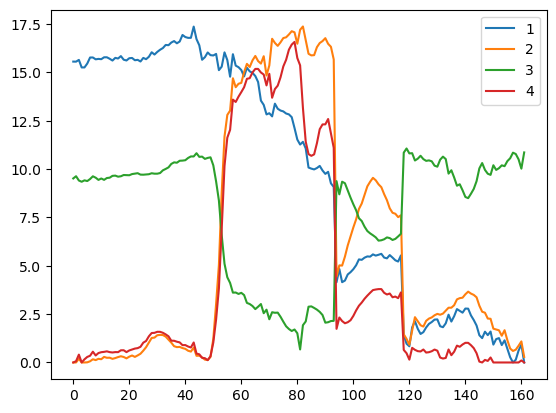

In [15]:
plt.plot(nmfW)
plt.legend([1, 2, 3, 4])

In [16]:
data = np.load('urban/2022_11_15/output/nmf_ini/nmf-ini-r4-it50000-l2.npz')
Wl = data['Wl']
Hl = data['Hl']
Wb = data['Wb']
Hb = data['Wb']
fscores = data['fscores']
gscores = data['gscores']
lambda_vals = data['lambda_vals']

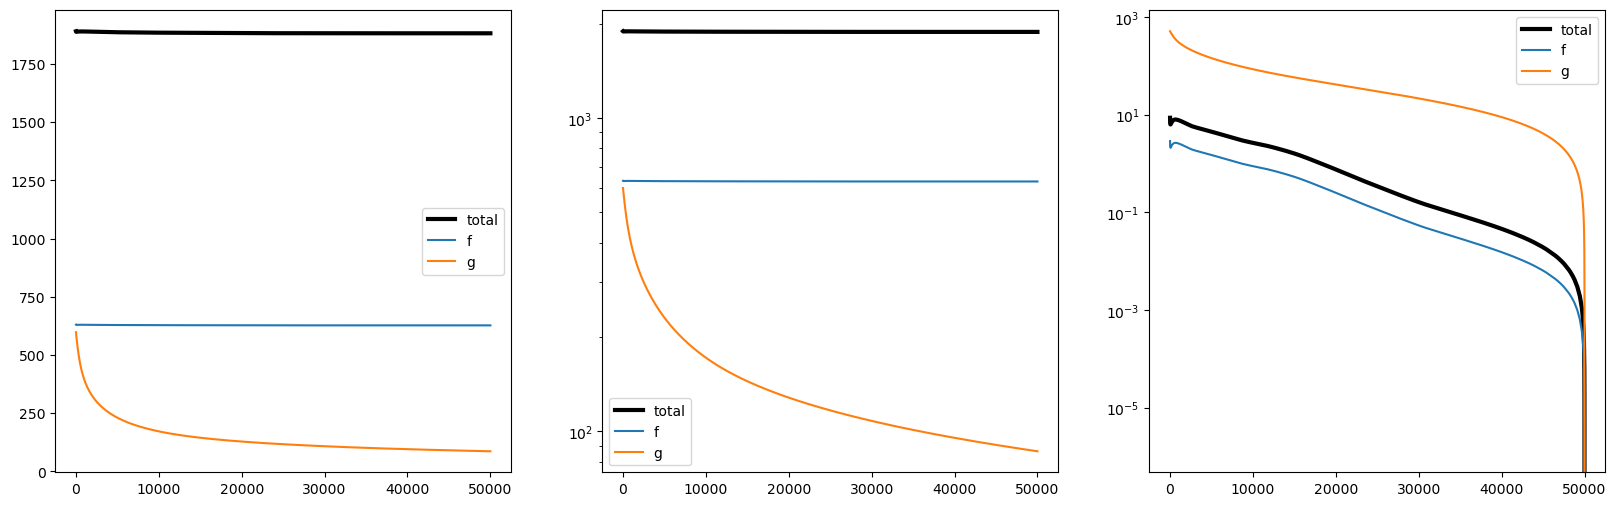

In [17]:
total_score = fscores + lambda_vals * gscores
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(total_score, color='black', linewidth=3, label='total')
axs[0].plot(fscores, label='f')
axs[0].plot(gscores, label='g')
axs[0].legend()

axs[1].set_yscale('log')
axs[1].plot(total_score, color='black', linewidth=3, label='total')
axs[1].plot(fscores, label='f')
axs[1].plot(gscores, label='g')
axs[1].legend()

axs[2].set_yscale('log')
axs[2].plot(total_score - total_score[-1], color='black', linewidth=3, label='total')
axs[2].plot(fscores - fscores[-1], label='f')
axs[2].plot(gscores - gscores[-1], label='g')
axs[2].legend()

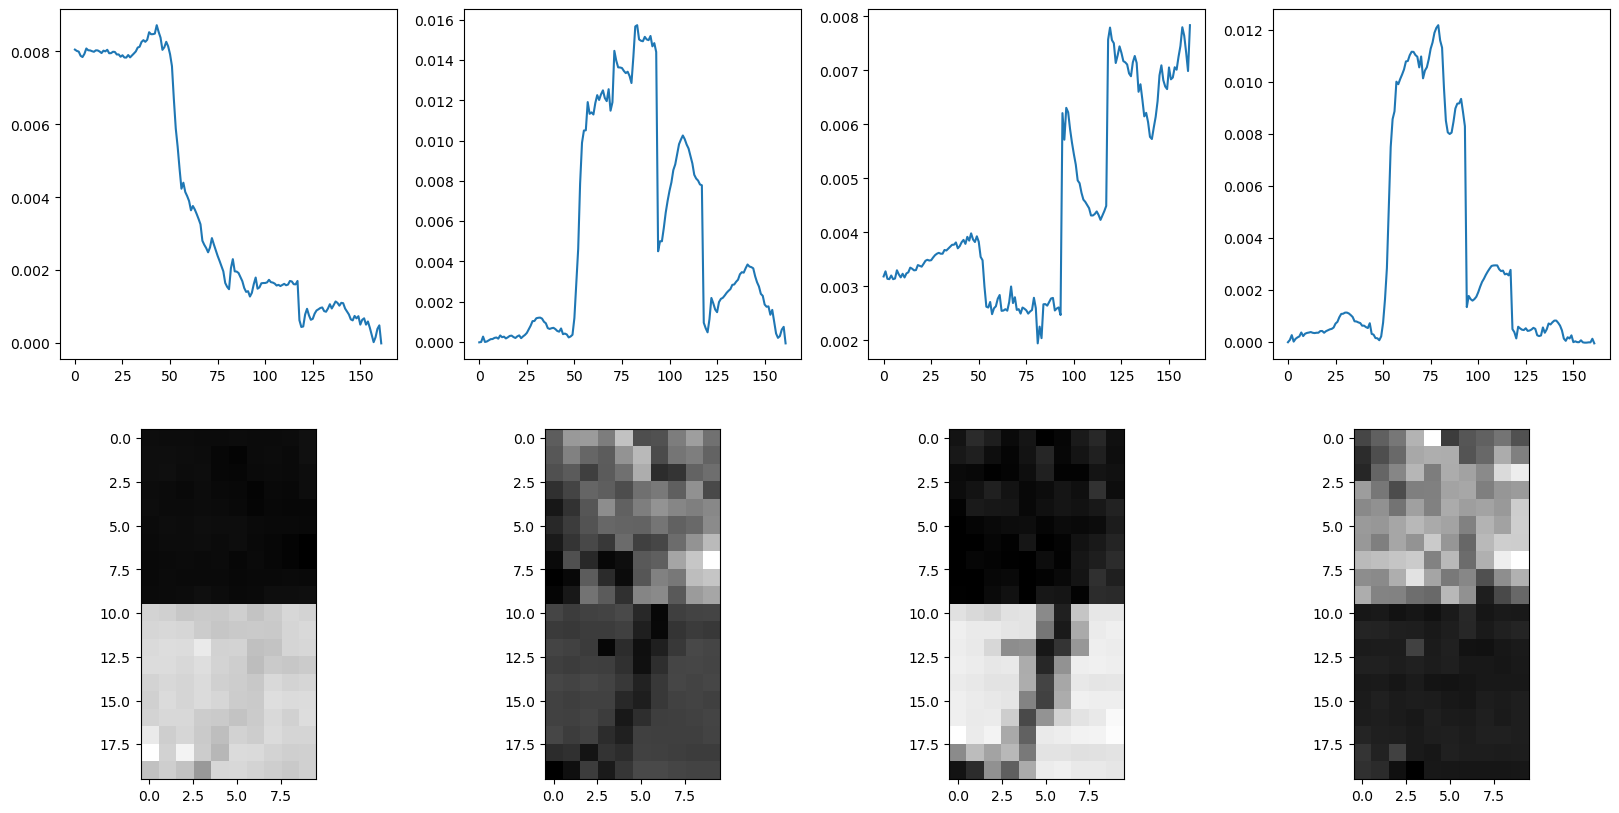

In [18]:
fig, axs = plt.subplots(2, rank, figsize=(20, 10))

for idx in range(rank):
    axs[0, idx].plot(Wl[:, idx] / np.dot(Wl[:, idx], Wl[:, idx]))
    axs[1, idx].imshow(Hl[idx, :].reshape(20, 10, order='F'), cmap='gray')

In [19]:
normalized_similarity(Wl)

array([[0.   , 0.327, 0.307, 0.366],
       [0.436, 0.   , 0.389, 0.175],
       [0.319, 0.303, 0.   , 0.378],
       [0.425, 0.153, 0.422, 0.   ]])